# Detecção de tendências em séries temporais com redes complexas

Alexandre Farias (9761826) \
João Luiz Veronezzi (9844853)

Todos os scripts encontrados junto com este notebook na pasta **timeseries**,\
até agora fazem:
- Extração de características (feature_engineering.py)
- Geração da rede (network_generation.py)
- Detecção de comunidades (community_detection.py)
- Rotulagem dos vetores de características (labelling.py)

Neste notebook, daremos continuidade com a detecção e previsão das tendências,\
através de um algoritmo de aprendizagem não supervisionada **K-Nearest Neighbors**,\
e validação do modelo com **backtest**.


### Importando bibliotecas necessárias

In [27]:
import pandas as pd
import numpy as np
import seaborn as sea
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt

### Importando conjunto de treino e teste

In [28]:
train = pd.read_csv("../data/iterim/feature_matrix_with_labels.csv")
test_all_data = pd.read_csv("../data/iterim/test.csv")
test = test_all_data.copy().loc[:, ["t", "community", "cp", "cpj", "X1", "X2", "X3", "X4", "X5", "X6"]]

print("Conjunto de treino")
train.head(3)

Conjunto de treino


,t,community,X1,X2,X3,X4,X5,X6,raw_price_label,smooth_price_label
0,1.0,2.0,1.0,0.2,1.0,0.2,1.0,0.4,1,1
1,2.0,2.0,1.0,0.2,1.0,0.2,1.0,0.4,1,1
2,3.0,2.0,1.0,0.2,1.0,0.2,1.0,0.4,1,1


In [29]:
print("Conjunto de teste")
test.head(3)

Conjunto de teste


,t,community,cp,cpj,X1,X2,X3,X4,X5,X6
0,5639,0.0,77891.0,76491.2,1.0,0.6,0.8,0.6,1.0,1.0
1,5640,0.0,77995.0,76952.6,1.0,0.8,1.0,0.6,1.0,1.0
2,5641,0.0,78647.0,77467.4,1.0,0.8,1.0,0.6,1.0,1.0


## Previsão das tendências

In [30]:
# definindo conjunto de treino e teste
X_train = train.loc[:, ["X1", "X2", "X3", "X4", "X5", "X6"]].values
X_test = test.loc[:, ["X1", "X2", "X3", "X4", "X5", "X6"]].values

# definindo rotulos para valores brutos e alisados
y_raw = train.loc[:, "raw_price_label"].values
y_smooth = train.loc[:, "smooth_price_label"].values

In [31]:
# criacao de 2 classificadores para treinar com os rotulos
# considerando valores brutos e alisados
classifier_raw = KNN(n_neighbors=1)
classifier_smooth = KNN(n_neighbors=1)

classifier_raw.fit(X_train, y_raw)
classifier_smooth.fit(X_train, y_smooth)

y_pred_raw = classifier_raw.predict(X_test)
y_pred_smooth = classifier_smooth.predict(X_test)

test["y_pred_raw"] = y_pred_raw
test["y_pred_smooth"] = y_pred_smooth

Deste modo, temos agora no conjunto de teste os rótulos,
considerando **cp** (y_pred_raw) e **cpj** (y_pred_smooth)

In [32]:
test.head(3)

,t,community,cp,cpj,X1,X2,X3,X4,X5,X6,y_pred_raw,y_pred_smooth
0,5639,0.0,77891.0,76491.2,1.0,0.6,0.8,0.6,1.0,1.0,1,1
1,5640,0.0,77995.0,76952.6,1.0,0.8,1.0,0.6,1.0,1.0,1,1
2,5641,0.0,78647.0,77467.4,1.0,0.8,1.0,0.6,1.0,1.0,1,1


# Implementação do backtest

In [33]:
def backtest(dataframe, price_col, label_col, balance_colname="balance"):
    test = dataframe.copy()
    test["cash"] = 0
    test["inv"] = 0
    test.loc[0, "cash"] = test.loc[0, price_col]

    cur_state = 0
    for i in range(1, len(test)):
        op_price = (test.loc[i, price_col] + test.loc[i - 1, price_col]) / 2
        pred = test.loc[i, label_col]

        if pred == 1:
            if cur_state == 0:
                cur_state = 1
                test.loc[i, "cash"] = test.loc[i-1, "cash"] - op_price
                test.loc[i, "inv"] = test.loc[i-1, "inv"] + op_price
            elif cur_state == 1:
                test.loc[i, "cash"] = test.loc[i-1, "cash"]
                test.loc[i, "inv"] = op_price
            else:
                cur_state = 0
                test.loc[i, "cash"] = test.loc[i-1, "cash"] - op_price
                test.loc[i, "inv"] = 0
        else:
            if cur_state == 0:
                cur_state = -1
                test.loc[i, "cash"] = test.loc[i-1, "cash"] + op_price
                test.loc[i, "inv"] = test.loc[i-1, "inv"] - op_price
            elif cur_state == 1:
                cur_state = 0
                test.loc[i, "cash"] = test.loc[i-1, "cash"] + op_price
                test.loc[i, "inv"] = 0
            else:
                test.loc[i, "cash"] = test.loc[i-1, "cash"]
                test.loc[i, "inv"] = -op_price

    test[balance_colname] = test["cash"] + test["inv"]
    
    return test

Geração do conjunto de teste com a coluna **balance**

In [34]:
test = backtest(test, "cp", "y_pred_raw", "balance_cp")
test = backtest(test, "cpj", "y_pred_smooth", "balance_cpj")

Por fim, temos as duas colunas com o saldo, considerando\
a série alisada e bruta:

In [35]:
test.head(3)

,t,community,cp,cpj,X1,X2,X3,X4,X5,X6,y_pred_raw,y_pred_smooth,cash,inv,balance_cp,balance_cpj
0,5639,0.0,77891.0,76491.2,1.0,0.6,0.8,0.6,1.0,1.0,1,1,76491.2,0.0,77891.0,76491.2
1,5640,0.0,77995.0,76952.6,1.0,0.8,1.0,0.6,1.0,1.0,1,1,-230.7,76721.9,77891.0,76491.2
2,5641,0.0,78647.0,77467.4,1.0,0.8,1.0,0.6,1.0,1.0,1,1,-230.7,77210.0,78269.0,76979.3


# Resultados

In [36]:
delta_balance_raw = (((test.balance_cp / test.balance_cp[0]) - 1) * 100).tolist()[-1]
delta_price_raw = (((test.cp / test.cp[0]) - 1) * 100).tolist()[-1]
diff_balance_price_raw = delta_balance_raw - delta_price_raw

delta_balance_smooth = (((test.balance_cpj / test.balance_cpj[0]) - 1) * 100).tolist()[-1]
delta_price_smooth = (((test.cpj / test.cpj[0]) - 1) * 100).tolist()[-1]
diff_balance_price_smooth = delta_balance_smooth - delta_price_smooth

In [37]:
diff_balance_price_raw

-31.91382829851974

## 1 Resultados percentuais dos modelos

||Rótulos com preços originais|Rótulos com preços alisados
---|---|---|
%bal|2.22|61.79
%pr|34.13|36.52
%bal - %pr|-31.91|25.26

## 2 Visualização dos resultados do backtest

### 2.1 Série original

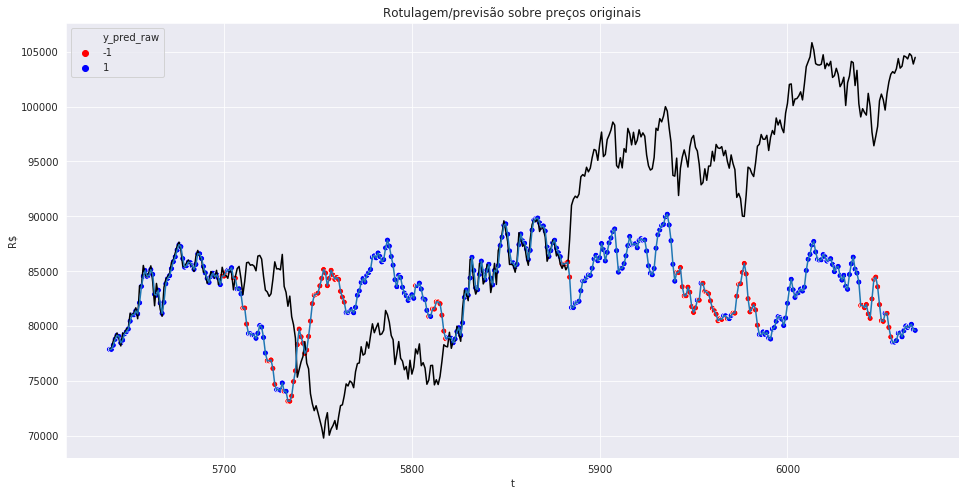

In [38]:
fig = plt.figure(figsize=(16, 8))
sea.set_style("darkgrid")
ax = sea.lineplot(data=test, x="t", y="cp", color="black")
ax = sea.lineplot(data=test, x="t", y="balance_cp")
ax = sea.scatterplot(data=test, x="t", y="balance_cp", hue="y_pred_raw", palette=["red", "blue"])
ax.set_title("Rotulagem/previsão sobre preços originais")
ax.set_ylabel("R$")
plt.show()

### 2.2 Série alisada

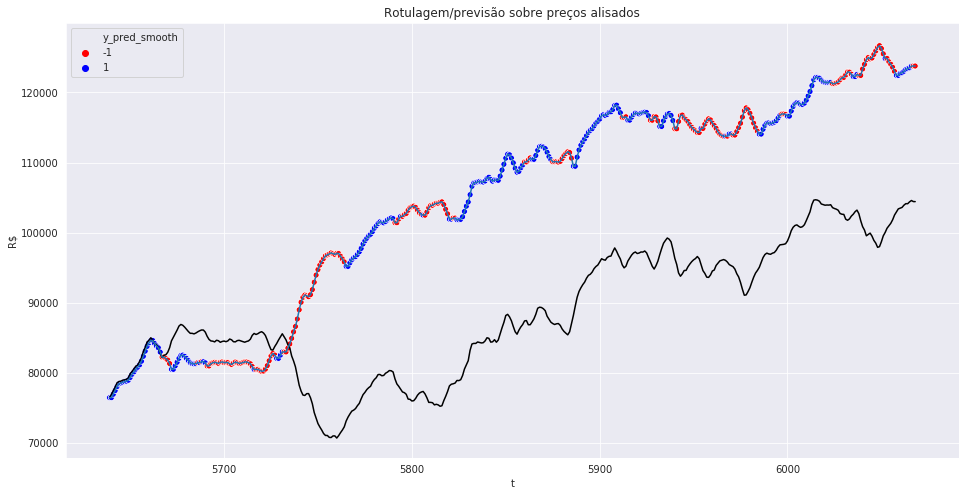

In [39]:
fig = plt.figure(figsize=(16, 8))
sea.set_style("darkgrid")
ax = sea.lineplot(data=test, x="t", y="cpj", color="black")
ax = sea.lineplot(data=test, x="t", y="balance_cpj")
ax = sea.scatterplot(data=test, x="t", y="balance_cpj", hue="y_pred_smooth", palette=["red", "blue"])
ax.set_title("Rotulagem/previsão sobre preços alisados")
ax.set_ylabel("R$")
plt.show()

## 3. Histograma com a distribuição das features do conjunto de treino

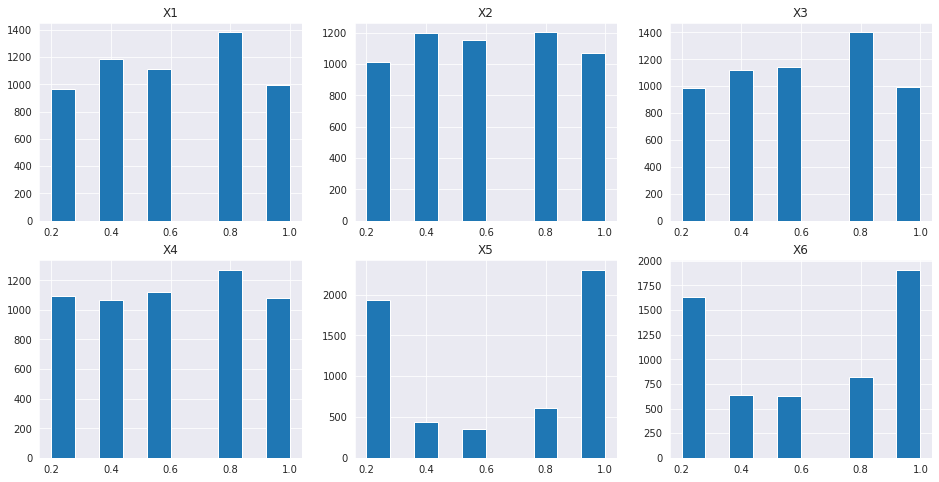

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

feature = 1
for row in [0, 1]:
    for col in [0 ,1 ,2]:
        feature_col = f"X{feature}"
        train[feature_col].hist(ax=axes[row, col])
        axes[row, col].set_title(feature_col)
        feature += 1

plt.show()

## 4. Distribuição das comunidades nos conjuntos de treino e teste

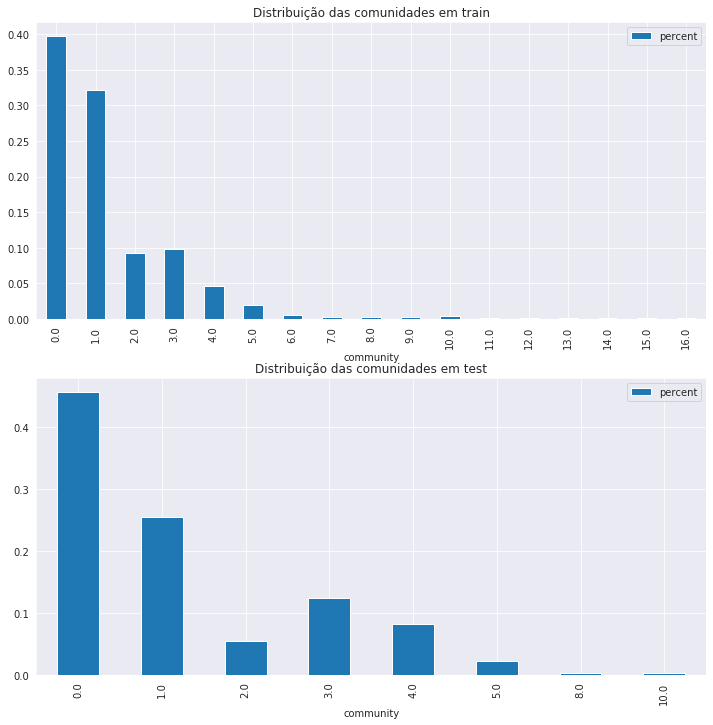

In [48]:
fig, axis = plt.subplots(2, figsize=(12, 12))

datasets = [
    ("train", train),
    ("test", test)
]

axis_id = 0
for name, dataset in datasets:
    total_communities = dataset.loc[:, ["community", "t"]].groupby("community")["t"].count().reset_index()
    total_communities["percent"] = total_communities["t"] / total_communities["t"].sum()
    total_communities.plot.bar(x="community", y="percent", ax=axis[axis_id])
    axis[axis_id].set_title(f"Distribuição das comunidades em {name}")
    axis_id += 1
    